In [1]:
# Spanish Wine Analysis:

# Importing needed libraries:

import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.cluster import Kmeans
import warnings
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from io import StringIO
from IPython.display import Image  
import pydotplus

warnings.filterwarnings("ignore", category=FutureWarning)


In [2]:
# importing, conducting exploratory data analysis and data cleansing:

df = pd.read_csv("wines_SPA.csv")
df.describe

<bound method NDFrame.describe of                     winery             wine  year  rating  num_reviews  \
0            Teso La Monja            Tinto  2013     4.9           58   
1                   Artadi    Vina El Pison  2018     4.9           31   
2             Vega Sicilia            Unico  2009     4.8         1793   
3             Vega Sicilia            Unico  1999     4.8         1705   
4             Vega Sicilia            Unico  1996     4.8         1309   
...                    ...              ...   ...     ...          ...   
7495               Contino          Reserva  2016     4.2          392   
7496  Conreria d'Scala Dei    Les Brugueres  2018     4.2          390   
7497           Mustiguillo  Finca Terrerazo  2017     4.2          390   
7498           Matarromera     Gran Reserva  2011     4.2          389   
7499              Sei Solo         Preludio  2016     4.2          388   

     country            region   price                  type  body  acidity  

In [3]:
""" df['winery'].nunique() # 480 entries
df['country'].nunique() # spain (only country)
df['region'].nunique() # 76 different regions
df['type'].nunique() # 21 different types
df['rating'].nunique() # 8 different ratings
df['wine'].nunique() # 847 different wines
df['year'].nunique() # 71 different years
df['num_reviews'].nunique() # 817 different reviews """

df_cleansed = df.dropna(axis=1)

C:\Users\Christopher K. Leal\AppData\Local\Temp\ipykernel_42864\1729619887.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleansed['Score'] = df_cleansed['rating'].apply(rating_vals)


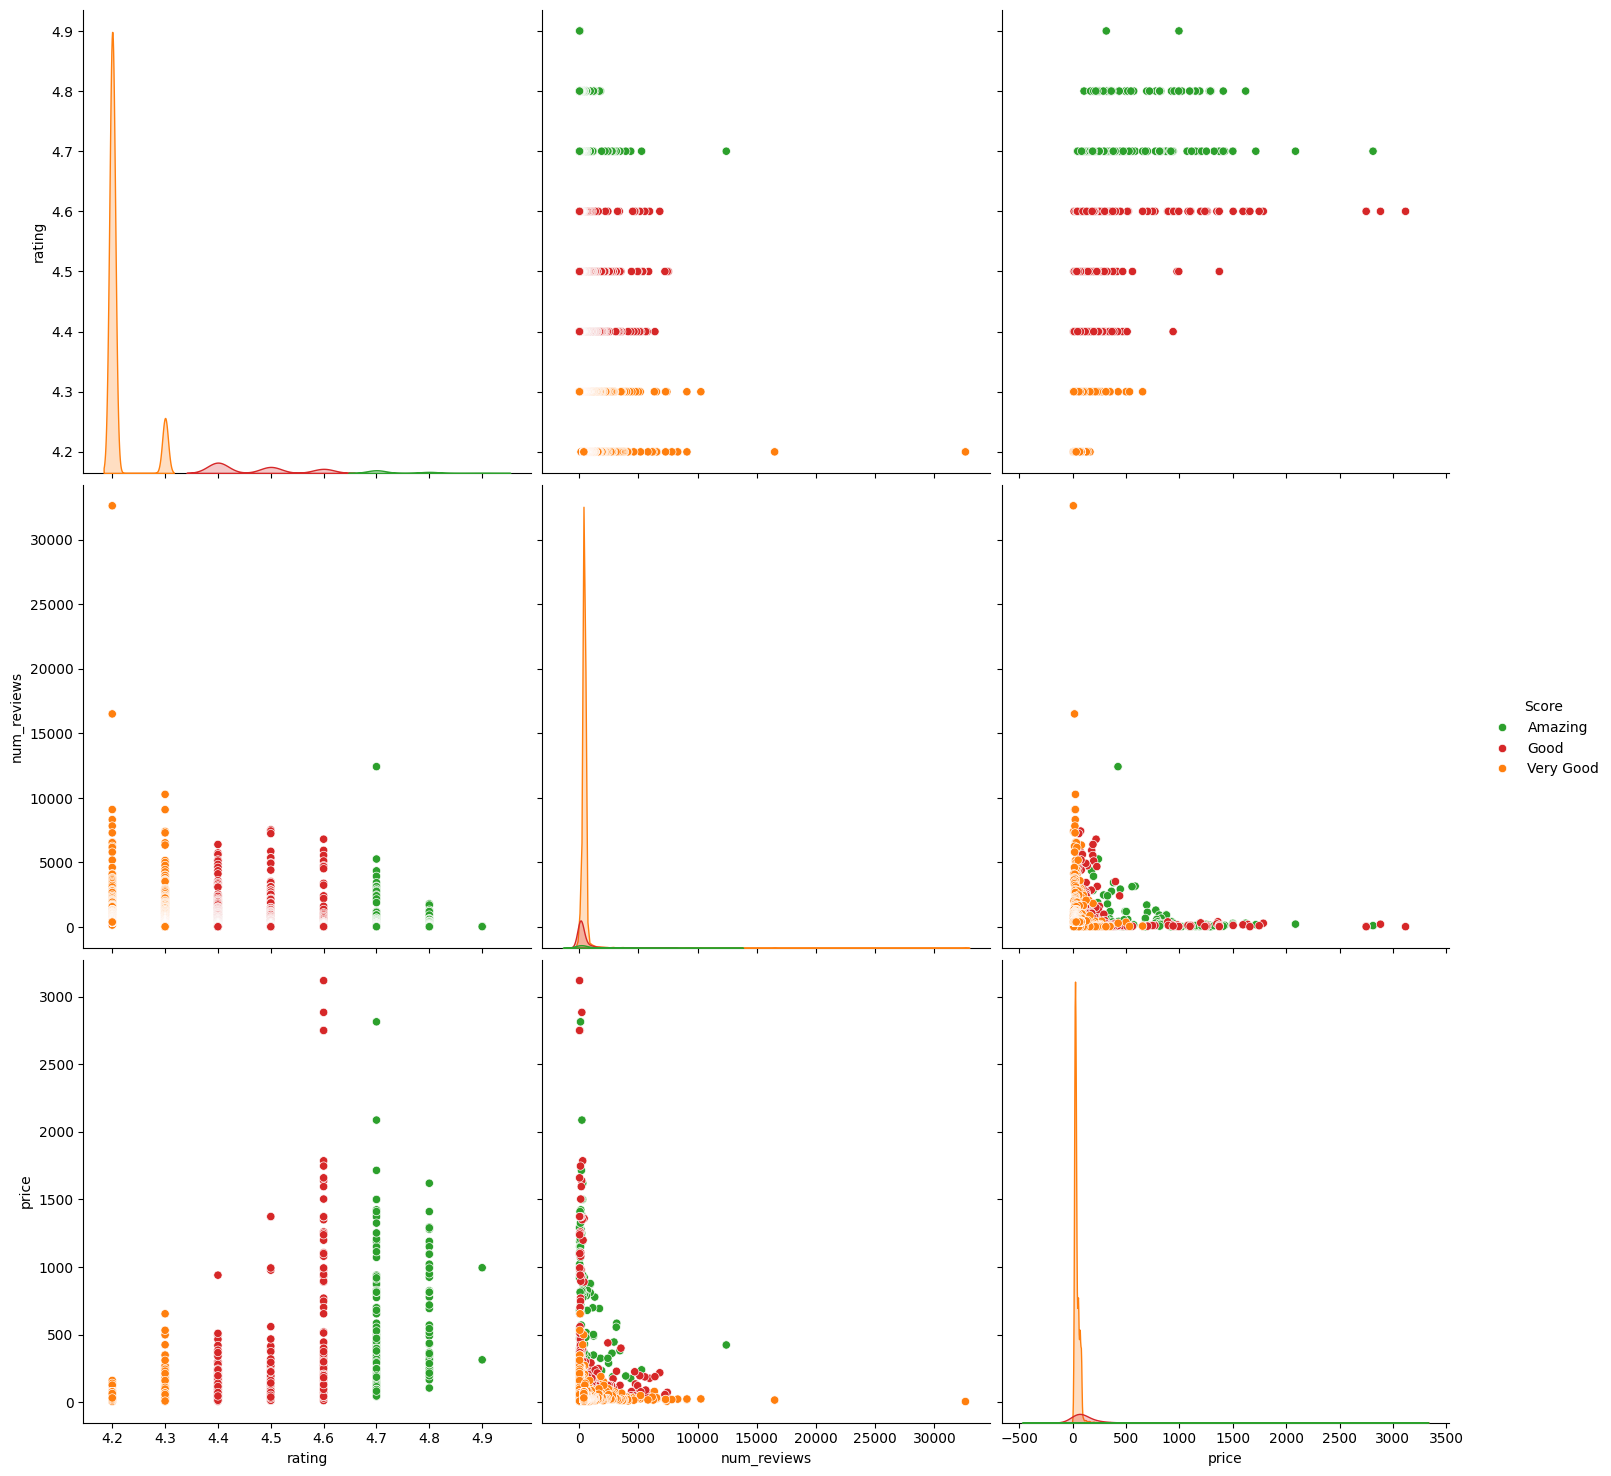

In [4]:
# Creating a function for color-coding ratings levels from Low to High:

def rating_vals(rating):
    if rating <= 4.3:
        return 'Very Good'
    elif rating >= 4.7:
        return 'Amazing'
    else:
        return 'Good'
    
df_cleansed['Score'] = df_cleansed['rating'].apply(rating_vals)

sns.pairplot(df_cleansed, hue='Score', palette={'Good':'tab:red','Very Good':'tab:orange', 'Amazing':'tab:green'}, height=5)


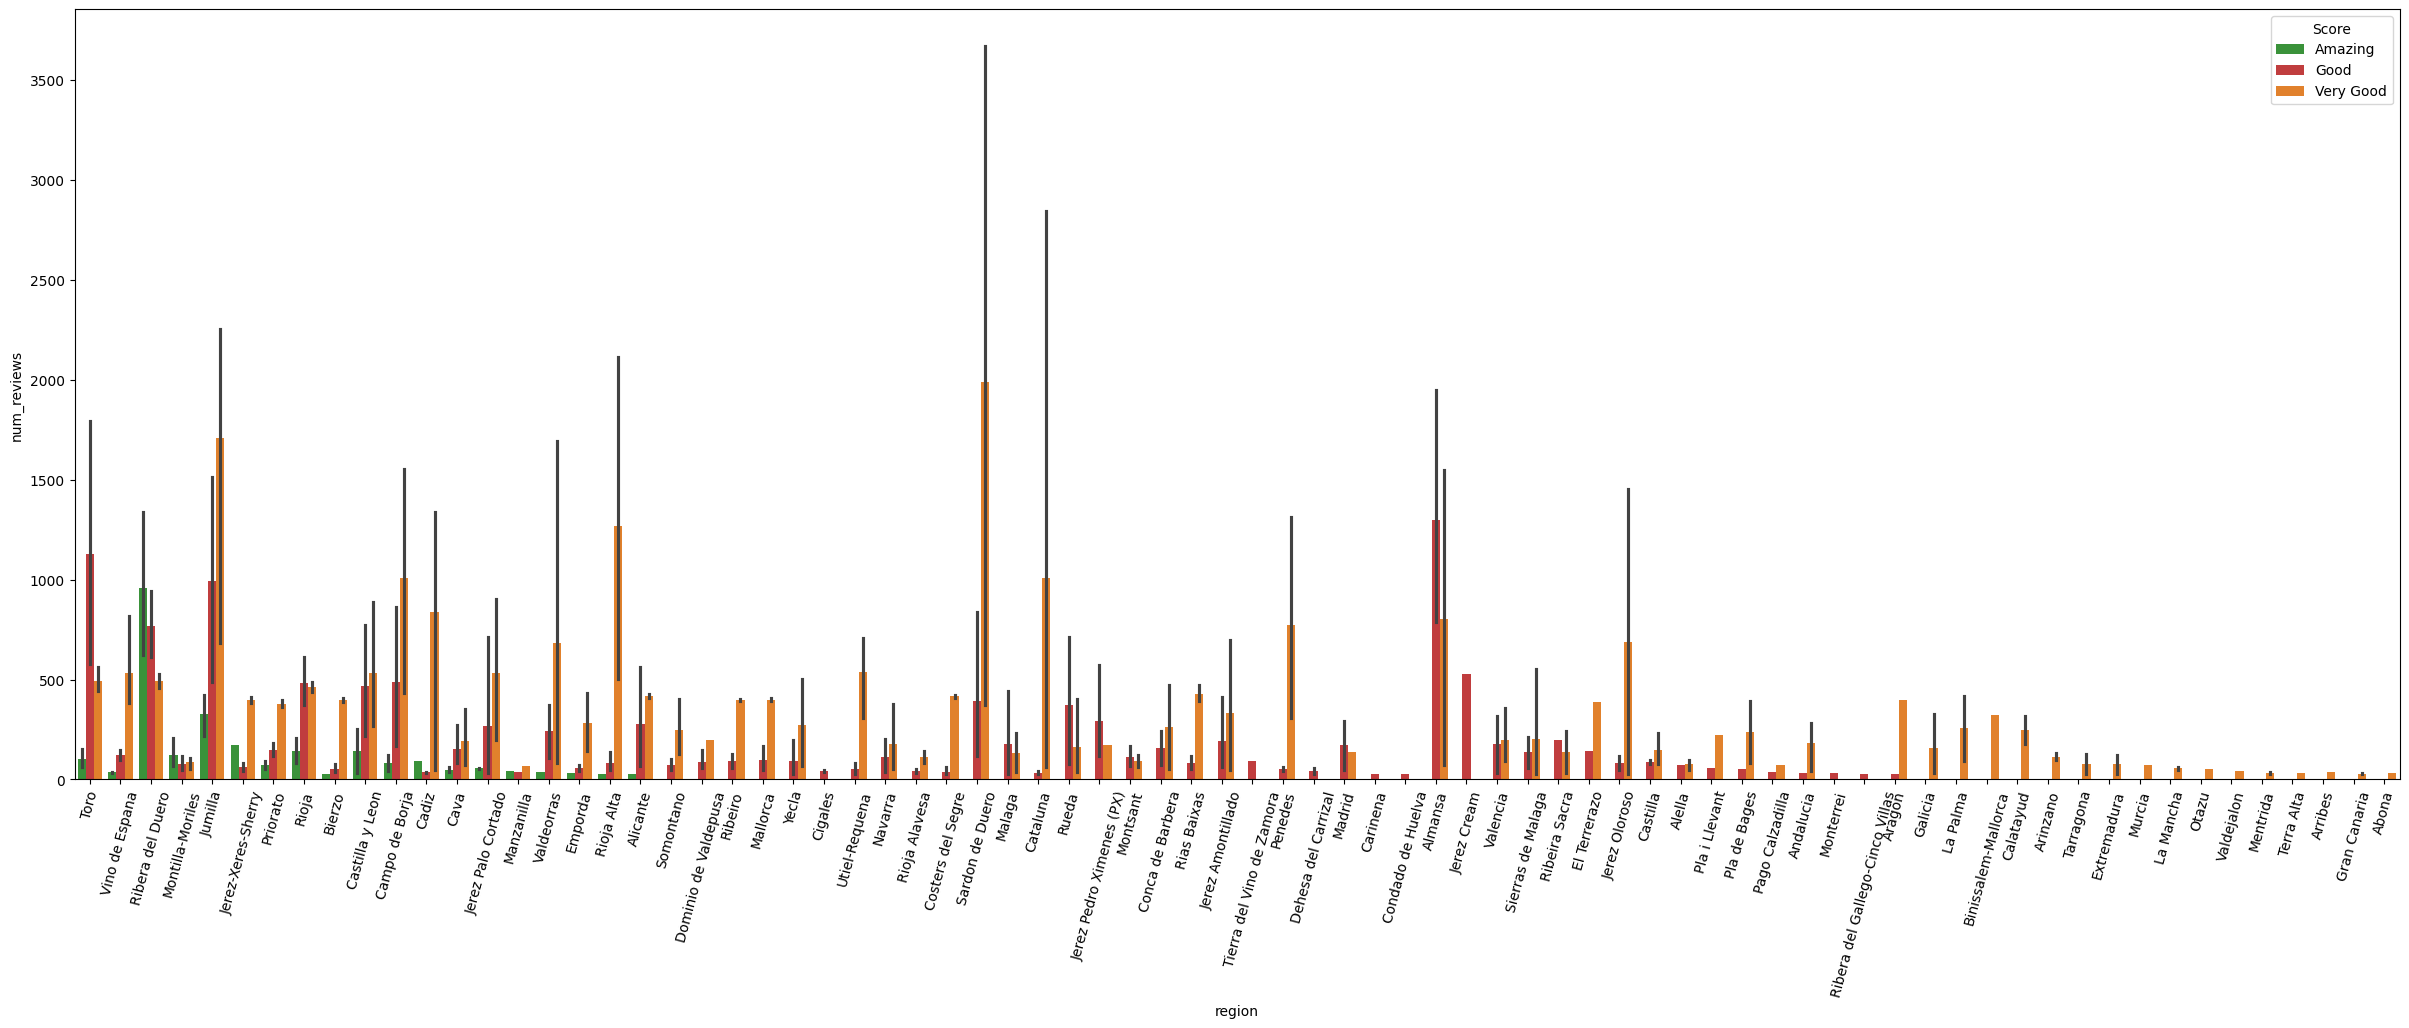

In [5]:
# The following plot leverages the same scoring function to view the results based on the region and showing the total number of reviews for each color:

plt.figure(figsize=[30, 10])
sns.barplot(data=df_cleansed, x='region', y='num_reviews', hue='Score', palette={'Good':'tab:red','Very Good':'tab:orange', 'Amazing':'tab:green'})
plt.xticks(rotation=75)
plt.show()

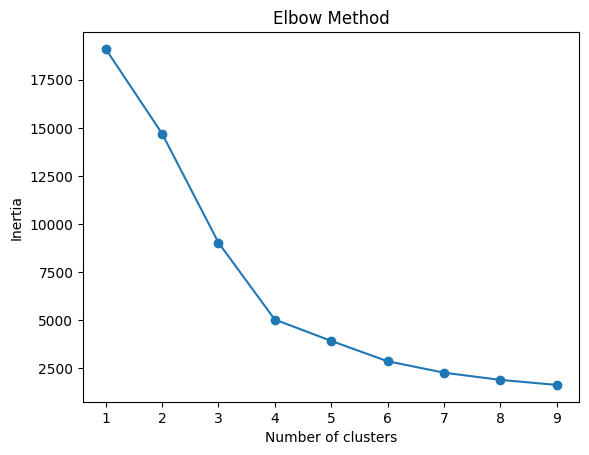

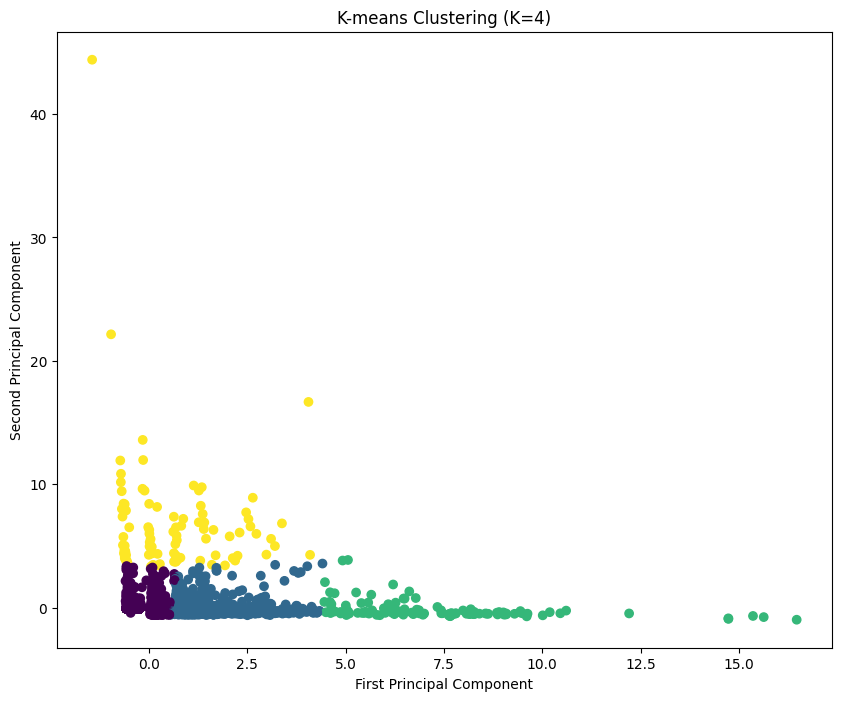

In [6]:
# Now, I'm curious to see how a K-Means clustering algorithm would work with this data.

df_kmeans_data = df_cleansed[['rating', 'num_reviews', 'price']]
df_onehot = pd.get_dummies(df_kmeans_data)

std_scaler = StandardScaler()
df_scaled = std_scaler.fit_transform(df_onehot)

wine_preprocessed = pd.DataFrame(df_scaled)

pca_scale = PCA(n_components=2)
df_pca = pca_scale.fit_transform(wine_preprocessed)

# Iterating to determine the best value for the number of clusters:

inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(df_pca)
    inertia.append(kmeans.inertia_)
plt.plot(range(1, 10), inertia, marker="o")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()

# Now that I know what value fits my model best, I will redo the fitting of the model and plot it out with the best value for 'K':

n_clusters = 4

plt.figure(figsize=[10,8])
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(df_pca)
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=kmeans.labels_, cmap="viridis")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.title(f"K-means Clustering (K={n_clusters})")
plt.show()

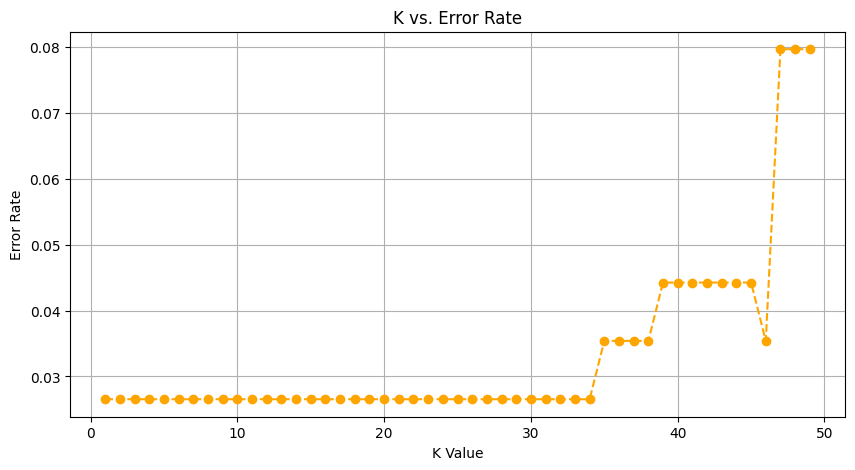

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        64
           1       1.00      0.94      0.97        49

    accuracy                           0.97       113
   macro avg       0.98      0.97      0.97       113
weighted avg       0.97      0.97      0.97       113



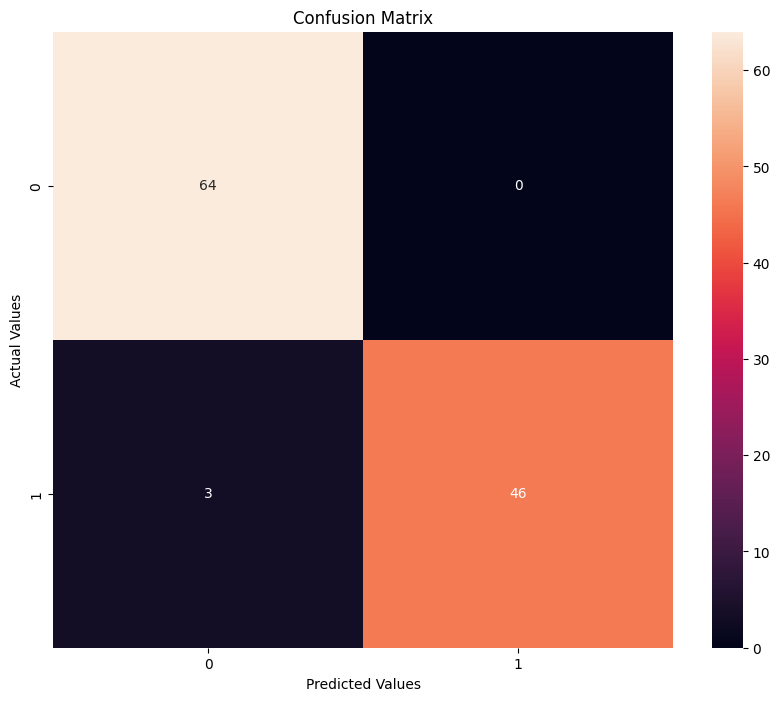

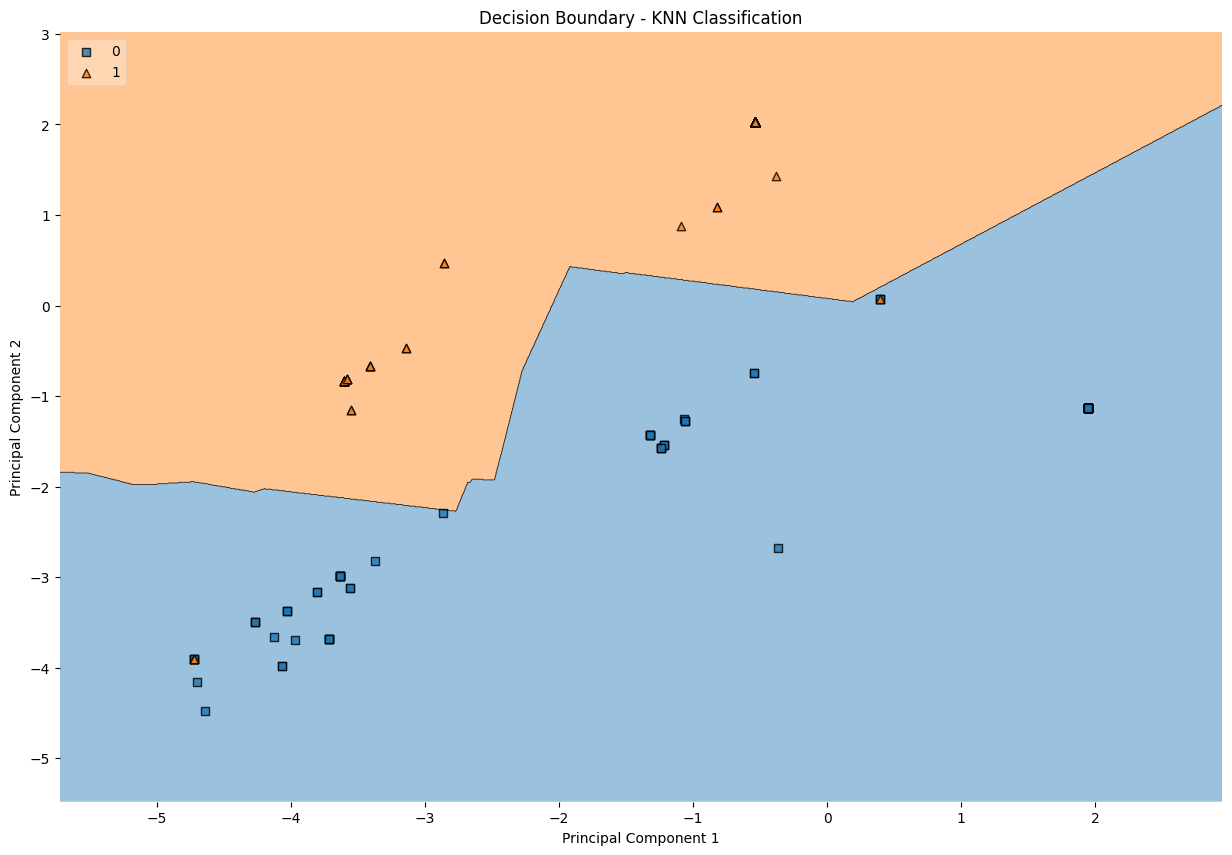

In [7]:
# Now, let's see how a KNN model looks. I will start back from df_cleansed:

specific_regions = ['Toro', 'Vino de Espana']
filtered_df = df_cleansed[df_cleansed['region'].isin(specific_regions)]

categorical_data = filtered_df[['winery', 'wine', 'country', 'Score']]
df_onehot = pd.get_dummies(categorical_data, columns=categorical_data.columns)

label_enc = LabelEncoder()
target = label_enc.fit_transform(filtered_df['region'])

X_train, X_test, Y_train, Y_test = train_test_split(df_onehot, target, random_state=42, test_size=0.2)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

error_rate = []

def KNN_loop():
    global error_rate
    error_rate = []
    for n_neighbors in range(1, 50):
        model = KNeighborsClassifier(n_neighbors=n_neighbors)
        model.fit(X_train_pca, Y_train)
        prediction = model.predict(X_test_pca)
        error_rate.append(np.mean(prediction != Y_test))

KNN_loop()

plt.figure(figsize=(10, 5))
plt.plot(range(1, 50), error_rate, color='orange', linestyle='--',  marker='o')
plt.xlabel('K Value')
plt.ylabel('Error Rate')
plt.grid()
plt.title('K vs. Error Rate')
plt.show()


# With this data, I can now plot the KNN classifier with the ideal value for K:

model = KNeighborsClassifier(n_neighbors=32)
model.fit(X_train_pca, Y_train)
final_prediction = model.predict(X_test_pca)

final_prediction_unencoded = label_enc.inverse_transform(final_prediction)
Y_test_unencoded = label_enc.inverse_transform(Y_test)

# Classification report
class_met = metrics.classification_report(Y_test, final_prediction)
print(class_met)

# Confusion matrix
conf_mat = metrics.confusion_matrix(Y_test_unencoded, final_prediction_unencoded)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.title("Confusion Matrix")
plt.show()

# Decision boundary plot (requires numerical Y labels)
plt.figure(figsize=(15, 10))
plot_decision_regions(X_train_pca, Y_train, clf=model, legend=2)
plt.title(f"Decision Boundary - KNN Classification")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()


The variance ratio is:  2


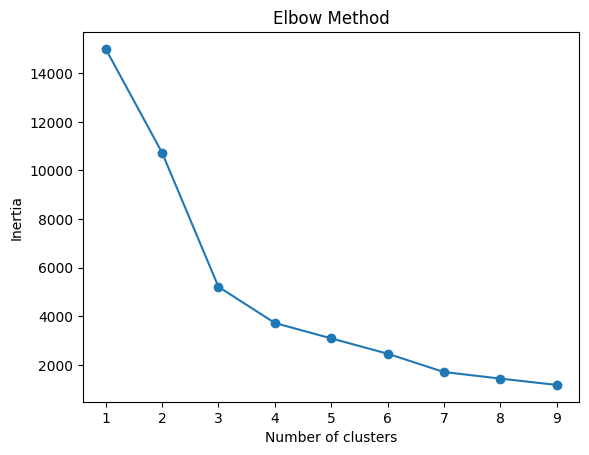

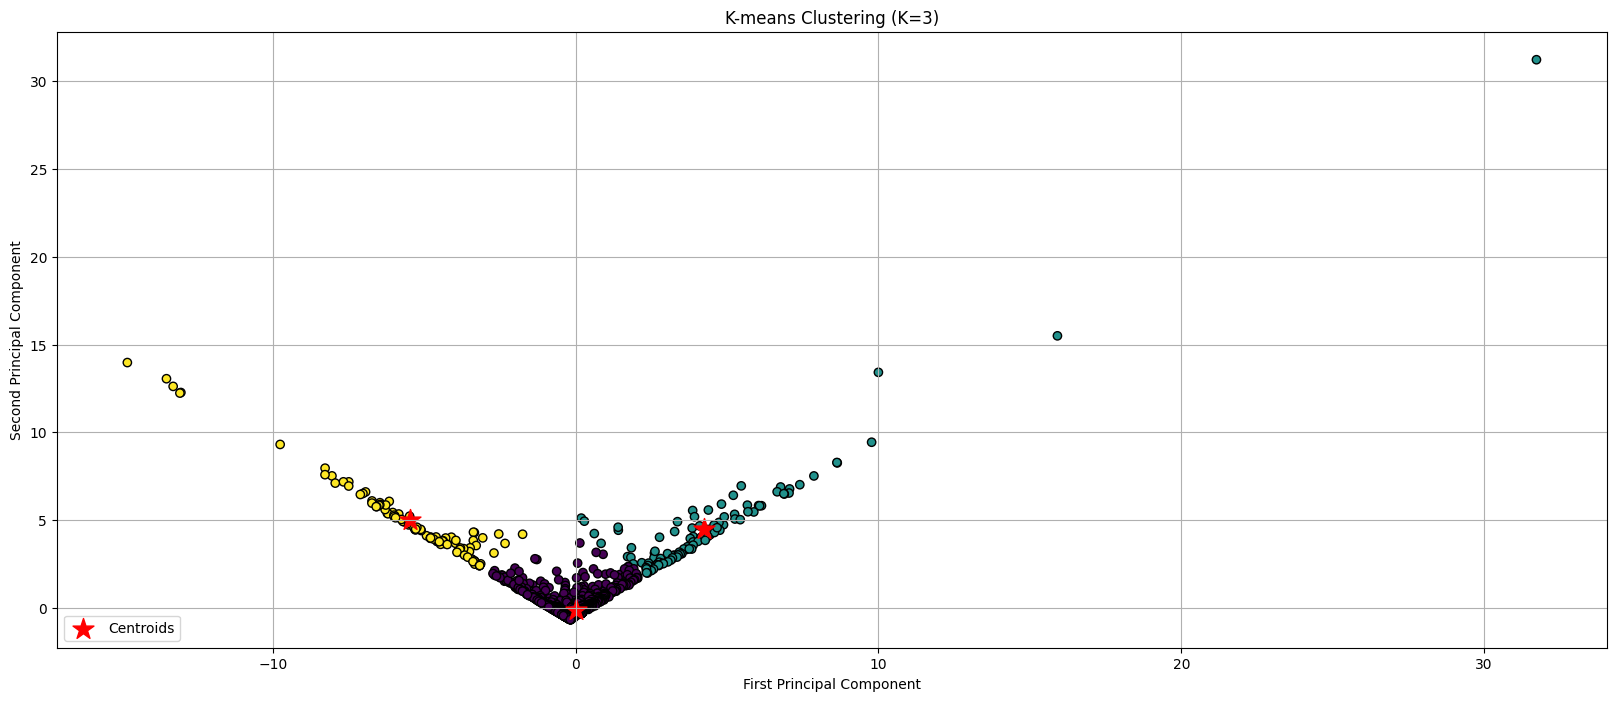

In [ ]:
# Next, I want to see what the data would look like when leveraging K-Means clustering for something more specific to see how else data can be visualized. 

df_cleansed.head()
reformated_df_cleansed = df_cleansed.drop(['region', 'country', 'winery', 'wine', 'rating', 'Score'], axis=1)


# Next, I scale the data and then perform dimesionality reduction with PCA:

std_data = scaler.fit_transform(reformated_df_cleansed)
dim_reduction = pca.fit(std_data)
dim_reduction.explained_variance_ratio_
n_components = sum(dim_reduction.explained_variance_ratio_ > 0.1)
data_dim_red = pca.fit_transform(std_data)
print("The variance ratio is: ", n_components)


# Elbow Plot used to determine the best value of 'K' for the number of clusters:

inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(data_dim_red)
    inertia.append(kmeans.inertia_)
plt.plot(range(1, 10), inertia, marker="o")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()
n_clusters = 3


# The following code block assigns the Kmeans model to a variable and is then used to plot the data including the centroids. See mlxtend documentation for details.

kmeans = KMeans(n_clusters=3, random_state=42).fit(data_dim_red)

plt.figure(figsize=[20, 8])
plt.scatter(data_dim_red[:, 0],data_dim_red[:, 1],c=kmeans.labels_, edgecolors='black')
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.title(f"K-means Clustering (K={n_clusters})")

# Plotting the centroids:
plt.scatter(kmeans.cluster_centers_[:, 0],kmeans.cluster_centers_[:, 1],s=250,marker='*',c='red',label='Centroids')

# Adding legends for clusters (but not indexing with `prediction`)
plt.legend(loc='lower left', scatterpoints=1)
plt.grid()
plt.show()

              precision    recall  f1-score   support

     Amazing       1.00      1.00      1.00        70
        Good       1.00      1.00      1.00       393
   Very Good       1.00      1.00      1.00      2537

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000



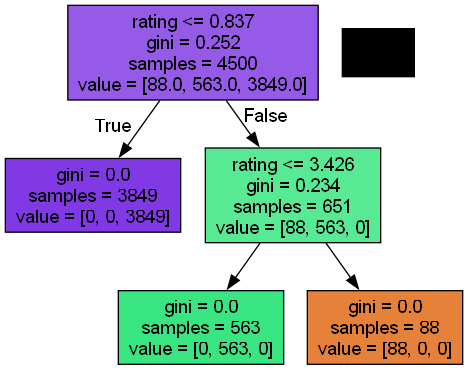

In [9]:
# The next thing I want to do is to create a Decision Tree that can assist me with creating a flowchart of how certain wines should be recommended.

X = df_cleansed.drop('Score', axis=1)
Y = df_cleansed['Score']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42, test_size=0.4)

X_train_encoded = pd.get_dummies(X_train)
X_test_encoded = pd.get_dummies(X_test)

X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)


X_train_scaled = std_scaler.fit_transform(X_train_encoded)
X_test_scaled = std_scaler.transform(X_test_encoded)

Tree = DecisionTreeClassifier(random_state=0)
Tree_model = Tree.fit(X_train_scaled, Y_train)
prediction = Tree_model.predict(X_test_scaled)

class_report = metrics.classification_report(Y_test, prediction)

print(class_report)


dot_data = StringIO()
export_graphviz(Tree_model, out_file=dot_data, filled=True, feature_names=X_train_encoded.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('Wines_Tree.png')
Image(graph.create_png())